In [80]:
# Import 
import time
import matplotlib.pyplot as plt
import numpy as np

## Objective Function. 

In [81]:
def x_star(t):
    return 10 + 5*np.sin(0.5 * t)

def objective(x, t, sigma=1.0):
    true_cost = (x - x_star(t))**2
    return true_cost + np.random.normal(0.0, sigma)


### Gradient Eestimate. PID Controller

In [82]:
def estimate_gradient_pid(f, x, t, eps=1e-4):
    return (f(x + eps, t) - f(x - eps, t)) / (2 * eps)


## PID Controller

In [83]:
class PIDController:
    def __init__(self, kp, ki, kd, setpoint=0, output_limits=(None, None)):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.min_out, self.max_out = output_limits
        self._prev_error = 0
        self._integral = 0
        self._last_time = None

    def update(self, current_value, current_time=None):
        if current_time is None:
            current_time = time.time()
        
        # Handle first run
        if self._last_time is None:
            self._last_time = current_time
            return 0.0
            
        dt = current_time - self._last_time
        if dt <= 0.0: return 0.0

        error = self.setpoint - current_value
        
        # Proportional Term
        P_term = self.kp * error

        # Integral Term (with Anti-Windup Clamping)
        self._integral += error * dt
        if self.max_out is not None and (self._integral * self.ki) > self.max_out:
            self._integral = self.max_out / self.ki
        elif self.min_out is not None and (self._integral * self.ki) < self.min_out:
            self._integral = self.min_out / self.ki
            
        I_term = self.ki * self._integral

        # Derivative Term
        derivative = (error - self._prev_error) / dt
        D_term = self.kd * derivative

        # Total Output
        output = P_term + I_term + D_term

        # Final Output Limiting
        if self.max_out is not None and output > self.max_out:
            output = self.max_out
        elif self.min_out is not None and output < self.min_out:
            output = self.min_out

        self._prev_error = error
        self._last_time = current_time

        return output

## Controller Runner

In [84]:
pid = PIDController(
    kp=3.0,
    ki=0.2,
    kd=0.4,
    setpoint=0,
    output_limits=(-5, 5)
)

x = 0.0
dt = 0.05
t = 0.0
steps = 1600

log = {"t": [], "x": [], "x_star": [], "grad": [], "u": []}

for _ in range(steps):
    grad = estimate_gradient_pid(objective, x, t)
    u = pid.update(grad, current_time=t)

    x += u * dt
    t += dt

    log["t"].append(t)
    log["x"].append(x)
    log["x_star"].append(x_star(t))
    log["grad"].append(grad)
    log["u"].append(u)

## Plots

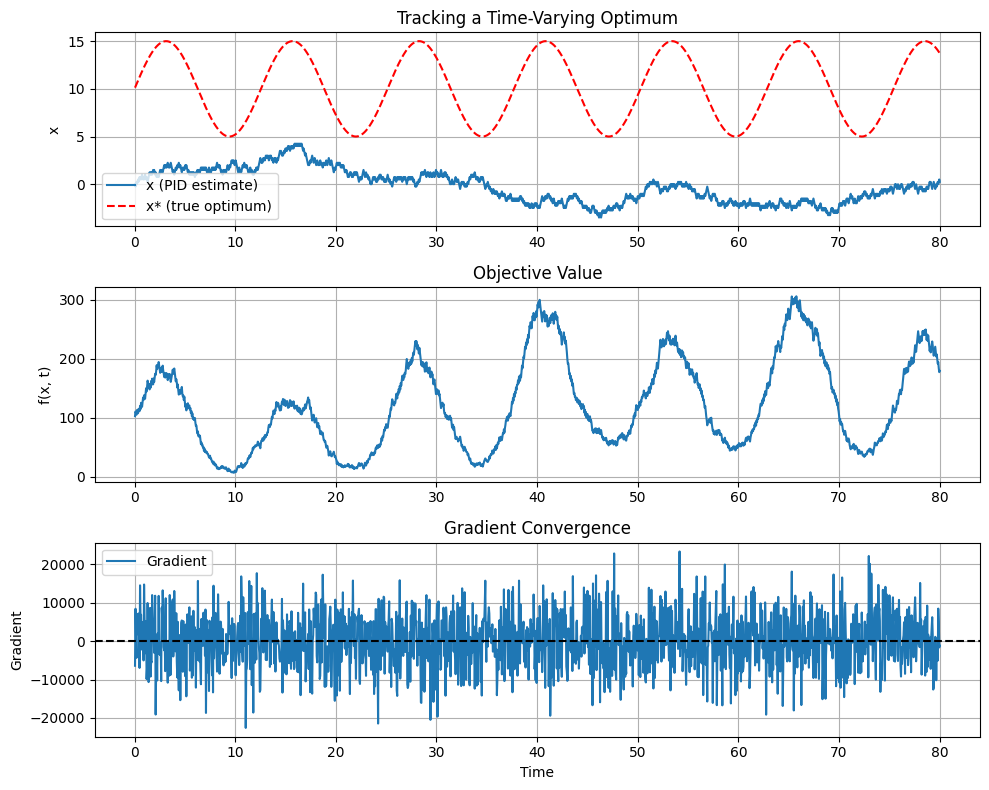

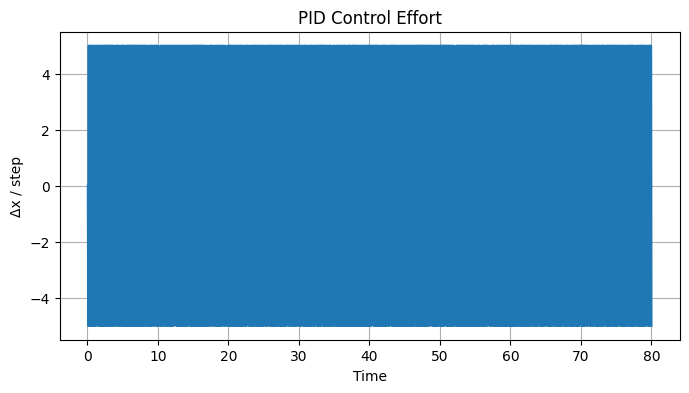

In [85]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(log["t"], log["x"], label="x (PID estimate)")
plt.plot(log["t"], log["x_star"], "r--", label="x* (true optimum)")
plt.ylabel("x")
plt.title("Tracking a Time-Varying Optimum")
plt.legend()
plt.grid(True)

f_vals = [objective(x, t) for x, t in zip(log["x"], log["t"])]

plt.subplot(3, 1, 2)
plt.plot(log["t"], f_vals)
plt.ylabel("f(x, t)")
plt.title("Objective Value")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(log["t"], log["grad"], label="Gradient")
plt.axhline(0, linestyle="--", color="k")
plt.xlabel("Time")
plt.ylabel("Gradient")
plt.title("Gradient Convergence")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(log["t"], log["u"])
plt.title("PID Control Effort")
plt.xlabel("Time")
plt.ylabel("Δx / step")
plt.grid(True)
plt.show()

### ES Controller Implementation 

In [86]:
from het_control.callbacks.utils import *

class esc:
    # cutoff_frequencies in rad/s
    def __init__(
        self,
        sampling_period,
        disturbance_frequency,
        disturbance_magnitude,
        integrator_gain,
        initial_search_value,
        high_pass_cutoff_frequency,
        low_pass_cutoff_frequency,
        use_adapter,
    ):
        self.dt = sampling_period  # in [s]
        self.disturbance_frequency = disturbance_frequency  # in rad/s
        self.disturbance_magnitude = disturbance_magnitude
        # negative for gradient descent
        self.integrator_gain = integrator_gain
        self.initial_search_value = initial_search_value
        # boolean, true or false (use the adapter or not)
        self.use_adapter = use_adapter

        self.high_pass_filter = High_pass_filter_first_order(
            sampling_period, high_pass_cutoff_frequency, 0, 0
        )
        self.low_pass_filter = Low_pass_filter_first_order(
            sampling_period, low_pass_cutoff_frequency, 0
        )
        # current phase of perturbation
        self.wt = 0

        self.min_setpoint = 0.0
        
        # integrator output
        self.integral = 0
        # estimated second moment
        self.m2 = 0
        self.b2 = 0.8
        # to prevent from dividing by zero
        self.epsilon = 1e-8

        return

    def update(self, cost):
        high_pass_output = self.high_pass_filter.apply(cost)
        low_pass_input = high_pass_output * np.sin(self.wt)
        low_pass_output = self.low_pass_filter.apply(low_pass_input)

        # if self.use_adapter:
        #     # Estimate the second moment (variance) of the gradient
        #     self.m2 = self.b2 * self.m2 + (1 - self.b2) * np.power(low_pass_output, 2)
        #     # Always normalize the gradient by its root mean square
        #     gradient = low_pass_output / (np.sqrt(self.m2) + self.epsilon)
        # else:
        #     gradient = low_pass_output

        self.m2 = self.b2 * self.m2 + (1 - self.b2) * np.power(low_pass_output, 2)
        gradient_mag = np.sqrt(self.m2)

        threshold = 0.2

        high_gain = -0.025  #0.1
        # low_gain =  -0.0015  #0.05

        if self.use_adapter:
            if gradient_mag > threshold:
                gain = high_gain
            else:
                gain = self.integrator_gain
        else:
            gain = self.integrator_gain


        self.integral += gain * low_pass_output * self.dt
        # setpoint = self.initial_search_value + self.integral
        
        # setpoint = max(setpoint, self.min_setpoint)

        setpoint_r = self.initial_search_value + self.integral

        # 2. Apply the clamp to get the actual setpoint
        setpoint = max(setpoint_r, self.min_setpoint)

        # 3. Correct the integrator state if clamping occurred
        if setpoint < self.min_setpoint:
            self.integral = self.min_setpoint - self.initial_search_value

        # output = self.disturbance_magnitude * np.sin(self.wt) + setpoint

        # perturbation = self.disturbance_magnitude * np.sin(self.wt) 

        a_min = 0.01
        a_max = self.disturbance_magnitude
        attenuation = gradient_mag / (gradient_mag + 1.0)
        a_eff = a_min + (a_max - a_min) * attenuation

        # --- Gain scheduling ---
        gain_scale = gradient_mag / (gradient_mag + 0.5)
        gain = gain * gain_scale

        self.integral += gain * low_pass_output * self.dt

        output = a_eff * np.sin(self.wt) + setpoint

        # update wt
        self.wt += self.disturbance_frequency * self.dt
        if self.wt > 2 * np.pi:
            self.wt -= 2 * np.pi

        return (
            output,
            high_pass_output,
            low_pass_output,
            gradient_mag,
            low_pass_output,
            setpoint,
        )

## SIM loop

In [87]:
dt = 0.05
steps = 1600
t = 0.0

esc_ctrl = esc(
    sampling_period=dt,
    disturbance_frequency=10.0,          # rad/s (must be > objective bandwidth)
    disturbance_magnitude=10.0,
    integrator_gain=-1.0,               # NEGATIVE for minimization
    initial_search_value=0.0,
    high_pass_cutoff_frequency=2.0,
    low_pass_cutoff_frequency=2.0,
    use_adapter=True,
)

log_esc = {
    "t": [],
    "x": [],
    "x_star": [],
    "cost": [],
    "setpoint": [],
    "grad_mag": [],
}

x = esc_ctrl.initial_search_value

for _ in range(steps):
    cost = objective(x, t)

    (
        x_new,
        hp,
        lp,
        grad_mag,
        _,
        setpoint,
    ) = esc_ctrl.update(cost)

    x = x_new
    t += dt

    log_esc["t"].append(t)
    log_esc["x"].append(x)
    log_esc["x_star"].append(x_star(t))
    log_esc["cost"].append(cost)
    log_esc["setpoint"].append(setpoint)
    log_esc["grad_mag"].append(grad_mag)


## Plots

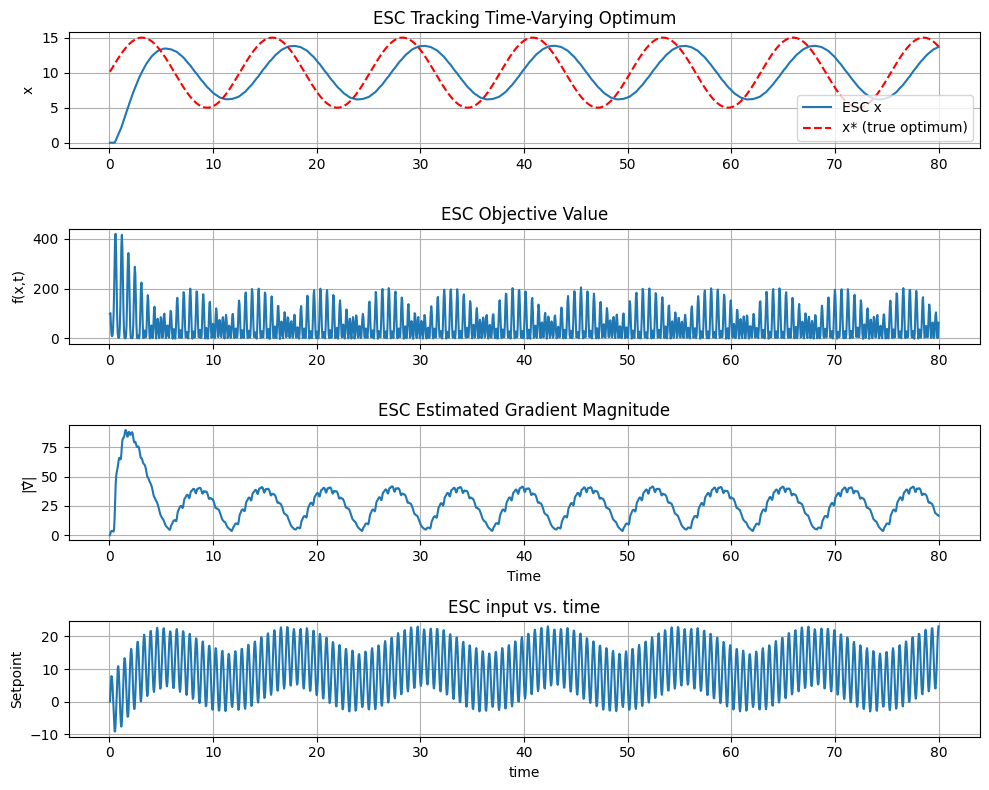

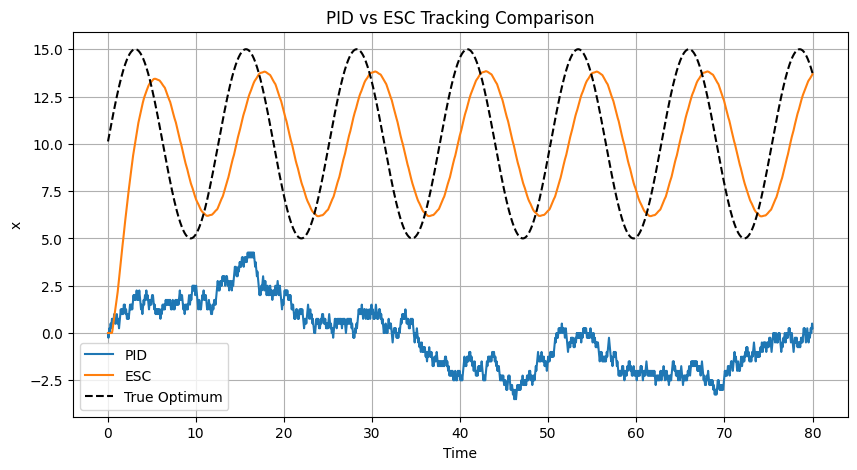

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(log_esc["t"], log_esc["setpoint"], label="ESC x")
plt.plot(log_esc["t"], log_esc["x_star"], "r--", label="x* (true optimum)")
plt.ylabel("x")
plt.title("ESC Tracking Time-Varying Optimum")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(log_esc["t"], log_esc["cost"])
plt.ylabel("f(x,t)")
plt.title("ESC Objective Value")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(log_esc["t"], log_esc["grad_mag"])
plt.xlabel("Time")
plt.ylabel("|∇̂|")
plt.title("ESC Estimated Gradient Magnitude")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(log_esc["t"], log_esc["x"])
plt.xlabel("time")
plt.ylabel("Setpoint")
plt.title("ESC input vs. time")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(log["t"], log["x"], label="PID")
plt.plot(log_esc["t"], log_esc["setpoint"], label="ESC")
plt.plot(log_esc["t"], log_esc["x_star"], "k--", label="True Optimum")
plt.xlabel("Time")
plt.ylabel("x")
plt.title("PID vs ESC Tracking Comparison")
plt.legend()
plt.grid(True)
plt.show()
